In [1]:
#Import Packages
import pandas as pd
import numpy as np
import os
import itertools
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import datetime
import matplotlib
from herbie import Herbie
import pickle
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates
import pysolar.solar as solar
from geographiclib.geodesic import Geodesic
import xarray as xr
import pytz
import simplekml
import cartopy
import sys
sys.path.append('..')
import funcs.ac_funcs as ac
import funcs.plotting as plotting


pd.options.mode.chained_assignment = None


#Autoreload changed local modules
%load_ext autoreload
%autoreload 2

In [ ]:
#base_project_dir = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/'
base_project_dir = '/Users/agmeyer4/LAIR_1/'


#SLC SOURCES
slc_sources = dict(
    landfill = {'salt_lake_valley':{'lat':40.746,'lon':-112.042},
                 'trans_jordan':{'lat':40.55862,'lon':-112.053},
                 'davis':{'lat':41.114,'lon':-111.931},
                 'weber':{'lat':41.218,'lon':-111.99},
                 'bountiful':{'lat':40.911,'lon':-111.917}},
    ww_plant = {'central_valley':{'lat':40.7036613,'lon':-111.9141398},
                 'big_cottonwood':{'lat':40.6187424,'lon':-111.7824328},
                 'se_regional':{'lat':40.5411975,'lon':-111.8191652},
                 'south_valley':{'lat':40.5033357,'lon':-111.9187493},
                 'slc':{'lat':40.8030915,'lon':-111.9295899},
                 },
    refinery = {'Chevron':        {'lat':40.825,'lon':-111.924},
                  'Big West Oil':   {'lat':40.838,'lon':-111.920},
                  'Marathon':       {'lat':40.794,'lon':-111.909},
                  'Holly Refining': {'lat':40.887,'lon':-111.904},
                  'Silver Eagle':   {'lat':40.868,'lon':-111.910}}
    )

source_df = pd.DataFrame()
for sourcetype in slc_sources.keys():
    df = pd.DataFrame(slc_sources[sourcetype]).transpose()
    df['type'] = sourcetype
    source_df = pd.concat([source_df,df])

In [ ]:
class stilt_output_handler:
    def __init__(self,stilt_base_output_path):
        self.stilt_base_output_path = stilt_base_output_path
        self.byid_path = os.path.join(stilt_base_output_path,'by-id')
        self.id_list = os.listdir(self.byid_path)
        self.id_dicts = {key: {} for key in self.id_list}
    
    def get_id_path(self,id):
        id_path = os.path.join(self.byid_path,id)
        return id_path
    
    def id_has_nc(self,id):
        files = os.listdir(self.get_id_path(id))
        if any('foot.nc' in file for file in files): #check if the footprint is in the list of files by looking for substring
            self.id_dicts[id]['has_nc'] = True
            self.id_dicts[id]['nc_fname']= [i for i in files if 'foot.nc' in i][0] #TODO find a way to do this without the list? shouldn't be multple nc file but sloppy
        else:
            self.id_dicts[id]['has_nc'] = False
        return True
    
    def check_all_for_nc(self):
        for id in self.id_list:
            self.id_has_nc(id)
    
    def get_meta_from_fname(self,fname):
        dt_str,lon_str,lat_str,zagl_str,run_id = fname.split('_')[:-1]
        lon = float(lon_str)
        lat = float(lat_str)
        zagl = float(zagl_str)
        run_id = int(run_id)
        return {'dt_str':dt_str,'lon':lon,'lat':lat,'zagl':zagl,'run_id':run_id}

    def get_all_meta(self):
        for id in self.id_dicts.keys():
            try:
                fname = self.id_dicts[id]['nc_fname']
            except:
                continue
                
            self.id_dicts[id].update(self.get_meta_from_fname(fname))
            self.id_dicts[id]['full_nc_path'] = os.path.join(self.get_id_path(id),fname)
            self.id_dicts[id]['id']=id

In [ ]:
my_stilt_handler = stilt_output_handler(f'/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/STILT/20230711_stilt/out')
my_stilt_handler.check_all_for_nc()
my_stilt_handler.get_all_meta()

stilt_footprints_df = pd.DataFrame(my_stilt_handler.id_dicts).transpose()
stilt_footprints_df['dt'] = pd.to_datetime(stilt_footprints_df['dt_str']).dt.tz_localize('UTC')
stilt_footprints_df = stilt_footprints_df.set_index('dt')
stilt_footprints_df_good =stilt_footprints_df.dropna()
stilt_footprints_df_good.index = stilt_footprints_df_good.index.tz_convert('US/Mountain')
stilt_footprints_df_good = stilt_footprints_df_good.sort_values('run_id')

# em27_data_folder = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct'
# tz = 'US/Mountain'
# dt_range = {'dt1':'2023-07-11 08:00:00','dt2':'2023-07-11 20:00:00'}
# oof_manage = ac.oof_manager(em27_data_folder,tz)
# em27_df = oof_manage.load_oof_df_inrange(dt_range['dt1'],dt_range['dt2'],True)
# em27_df = em27_df.resample('T').mean()
# species = 'xch4(ppm)'

In [ ]:
my_stilt_handler = stilt_output_handler(f'/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/STILT/20230809_stilt/out')
my_stilt_handler.check_all_for_nc()
my_stilt_handler.get_all_meta()

stilt_footprints_df = pd.DataFrame(my_stilt_handler.id_dicts).transpose()
stilt_footprints_df['dt'] = pd.to_datetime(stilt_footprints_df['dt_str']).dt.tz_localize('UTC')
stilt_footprints_df = stilt_footprints_df.set_index('dt')
stilt_footprints_df_good =stilt_footprints_df.dropna()
stilt_footprints_df_good.index = stilt_footprints_df_good.index.tz_convert('US/Mountain')
stilt_footprints_df_good = stilt_footprints_df_good.sort_values('run_id')

em27_data_folder = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct'
tz = 'US/Mountain'
dt_range = {'dt1':'2023-08-09 08:00:00','dt2':'2023-08-09 20:00:00'}
oof_manage = ac.oof_manager(em27_data_folder,tz)
em27_df = oof_manage.load_oof_df_inrange(dt_range['dt1'],dt_range['dt2'],True)
em27_df = em27_df.resample('T').mean()
species = 'xch4(ppm)'

In [ ]:
save_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Figures/oct2023/STILT/20230711/'

min_foot = 0.001
j = 0
for dt in stilt_footprints_df_good.index.unique():
    if j==0:
        j+=1
        continue
    sub_df = stilt_footprints_df_good.loc[stilt_footprints_df_good.index == dt]

    fp = sub_df.iloc[0]
    full_nc_path = fp['full_nc_path']
    ds = xr.open_dataset(full_nc_path)
    summed_da = ds.sum(dim='time')
    foot_sum = summed_da.foot

    for i in range(1,len(sub_df)):
        fp = sub_df.iloc[i]
        full_nc_path = fp['full_nc_path']
        ds = xr.open_dataset(full_nc_path)
        summed_da = ds.sum(dim='time')
        foot_da = summed_da.foot
        foot_sum = foot_sum + foot_da

    foot_sum_masked = foot_sum.where(foot_sum>min_foot)

    inst_lat = 40.766
    inst_lon = -111.847
    extent=[-112.3,-111.5,40.5,41.0]
    labsize = 14

    zoom = 0.2
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection = proj)
    ax.set_extent(extent,crs=proj)

    request = cimgt.GoogleTiles(style='satellite')
    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    ax.add_image(request,int(scale))
    footplot = foot_sum_masked.plot(ax=ax,transform=proj,add_colorbar=False,alpha = 0.65)
    cbar = plt.colorbar(footplot,fraction=0.028)
    cbar.ax.tick_params(labelsize=labsize)
    cbar.set_label(label = 'STILT Footprint (not weighted)',size=labsize)

    colors = ['#CC3311','#0077BB','#F4BB44']
    i= 0
    for source_type in source_df.groupby('type').sum().index:
        minidf = source_df.loc[source_df['type'] ==source_type]
        ax.scatter(minidf['lon'],minidf['lat'],label=source_type,c=colors[i],s=40)
        i+=1

    ax.scatter(inst_lon,inst_lat,label='EM27',marker='x',c='k',s=70)
    t = ax.text(extent[1]-.17,extent[2]+.02,f'{dt.hour:02}:{dt.minute:02}{"MDT"}',fontsize=20,color='k')
    t.set_bbox(dict(facecolor='white', alpha=0.7))

    axins = inset_axes(ax,width='40%',height='20%',loc='lower left')
    axins.scatter(em27_df.index,em27_df[species],color = 'blue',zorder=3,s=1)
    # axins.errorbar(em27_df.index,em27_df[species],
    #                 yerr=em27_df[f'{species}_error'],ls='none',
    #                 ecolor='grey',alpha=0.2)
    axins.tick_params(labelsize = labsize)
    axins.set_ylabel(species,size = labsize)
    axins.vlines(dt,axins.get_ylim()[0],axins.get_ylim()[1],zorder = 10,linewidth=5,color = 'grey',alpha = 0.5)
    axins.xaxis.set_major_locator(mdates.HourLocator(interval=2))   
    axins.xaxis.set_major_formatter(mdates.DateFormatter('%H', tz = em27_df.index.tz))
    axins.set_xlabel(em27_df.index[0].strftime('%Z %b %d, %Y'),size = labsize)
    ax.legend(fontsize=labsize,loc = 0)
    plt.gcf().autofmt_xdate()
    plt.show()
    savename = f"{dt.hour:02}.png"
    fig.savefig(os.path.join(save_path,savename),dpi=500)
    


In [ ]:
min_foot = 0.00

for idx in range(len(stilt_footprints_df_good)):
#idx = 72
    fp = stilt_footprints_df_good.iloc[idx]
    full_nc_path = fp['full_nc_path']
    lat = fp['lat']
    lon = fp['lon']
    zagl = fp['zagl']
    dt_str = fp['dt_str']
    dt = fp.name
    id = fp.id

    inst_lat = 40.766
    inst_lon = -111.847

    ds = xr.open_dataset(full_nc_path)
    summed_da = ds.sum(dim='time')
    foot = summed_da.foot
    masked_foot = foot.where(foot>min_foot)

    extent=[-112.3,-111.5,40.5,41.0]


    species = 'xch4(ppm)'
    labsize = 14

    stilt_footprint_png_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Figures/'
    stilt_footprint_png_fname = f'{id}.png'

    print(id)
    zoom = 0.2
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection = proj)
    ax.set_extent(extent,crs=proj)

    request = cimgt.GoogleTiles(style='satellite')
    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    ax.add_image(request,int(scale))
    #contour = ax.contourf(summed_da['lon'],summed_da['lat'],summed_da.foot,transform = proj , alpha = 0.9,vmin=min_foot)
    foot = masked_foot.plot(ax=ax,transform=proj,add_colorbar=False,alpha = 0.65)
    cbar = plt.colorbar(foot,fraction=0.033)
    cbar.ax.tick_params(labelsize=labsize)
    cbar.set_label(label = 'STILT Footprint',size=labsize)

    colors = ['#CC3311','#0077BB','#F4BB44']
    i= 0
    for source_type in source_df.groupby('type').sum().index:
        minidf = source_df.loc[source_df['type'] ==source_type]
        ax.scatter(minidf['lon'],minidf['lat'],label=source_type,c=colors[i],s=40)
        i+=1

    t = ax.text(extent[1]-.2,extent[2]+.02,f'{dt.month}-{dt.day} {dt.hour}:{dt.minute:02}{"MDT"}\n{zagl}m agl',fontsize=20,color='k')
    t.set_bbox(dict(facecolor='white', alpha=0.7))

    ax.scatter(inst_lon,inst_lat,label='EM27',marker='x',c='k',s=70)

    # axins = inset_axes(ax,width='40%',height='20%',loc='lower left')
    # axins.scatter(em27_df.index,em27_df[species],color = 'grey',zorder=3,label='True Data Rate',s=1)
    # axins.errorbar(em27_df.index,em27_df[species],
    #                 yerr=em27_df[f'{species}_error'],ls='none',
    #                 ecolor='grey',alpha=0.2)
    # axins.tick_params(labelsize = labsize)
    # axins.set_ylabel(species,size = labsize)
    # axins.vlines(dt,axins.get_ylim()[0],axins.get_ylim()[1],zorder = 10,linewidth=5)
    # axins.xaxis.set_major_formatter(mdates.DateFormatter('%H', tz = em27_df.index.tz))
    # axins.set_xlabel(em27_df.index[0].strftime('%Z %b %d, %Y'),size = labsize)
    # plt.gcf().autofmt_xdate()

    ax.legend(fontsize=labsize)
    plt.show()
    #fig.savefig(os.path.join(stilt_footprint_png_path,stilt_footprint_png_fname),bbox_inches='tight')

# Stilt loader with id scheme

In [44]:
class stilt_rec_handler:
    def __init__(self,rec_csv_fullpath):
        self.rec_csv_fullpath = rec_csv_fullpath

    def full_recfile_load(self):
        self.parse_rec_header()
        self.rec_df = self.read_rec_csv()
        self.split_dfs = self.split_recdf_bytime()
        

    def parse_rec_header(self):
        '''Read the header of the receptor file and store the data in the class'''

        with open(self.rec_csv_fullpath) as f: #open the file
            header_lines = [] #initialize a list of the header lines
            line = ' ' #make line a space to get into the while loop
            while line != '': #the header should be followed by a blank line. stop after we read that
                line = f.readline().strip() #read the line and strip the newline character
                header_lines.append(line) #append the line to the header_lines list

        for line in header_lines: #loop through the header lines
            if line.split(':')[0] == 'Instrument Location': #ge the instrument location
                inst_loc_vals = line.split(':')[-1]
                self.inst_lat = float(inst_loc_vals.split(',')[0].strip(' ,'))
                self.inst_lon = float(inst_loc_vals.split(',')[1].strip(' ,'))
                self.inst_zasl = float(inst_loc_vals.split(',')[2].strip(' ,masl'))
            if line.split(':')[0] == 'Datetime range': #get the datetime range
                inst_dt_vals = line.split('Datetime range:')[-1]
                self.dt_range_strs = [inst_dt_vals.split(' to ')[0],inst_dt_vals.split(' to ')[1]]
            if line.split(':')[0] == 'Data date':
                self.data_datestr = line.split(':')[1].strip()
        
    def read_rec_csv(self):
        '''Reads the actual data in the receptor file to a pandas dataframe for later reference'''
        rec_df = pd.read_csv(self.rec_csv_fullpath,header = 6)
        rec_df['run_times'] = pd.to_datetime(rec_df['run_times'])
        return rec_df    

    def split_recdf_bytime(self):
        '''Splits the receptor dataframe into a list of dataframes, with each having the same run_time (the vertical levels for that run_time)
        
        Returns:
        split_dfs (list): list of dataframes, where each is a dataframe of a single run time representing the vertical levels
        '''
       
        split_dfs = [] #initialize the timegrouped list
        for name, group in self.rec_df.groupby('run_times'): #groupby runtime
            sub_df = group.copy() #copy to avoid overwriting
            split_dfs.append(sub_df) #append the df to the list

        return split_dfs    

all_stilt_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/'
project_dir = '20230711_stilt'
rec_csv_fullpath = os.path.join(all_stilt_path,project_dir,'receptors','20230711_100000_235959.csv')

stilt_rec = stilt_rec_handler(rec_csv_fullpath)
stilt_rec.full_recfile_load()

,run_times,lati,long,zagl,z_is_agl,sim_id,zasl,zail
0,2023-07-11 14:00:00+00:00,40.7660,-111.8470,29.0,True,0,1470.0,0
1,2023-07-11 14:00:00+00:00,40.7675,-111.8387,245.0,True,1,1720.0,250
2,2023-07-11 14:00:00+00:00,40.7689,-111.8304,441.0,True,2,1970.0,500
3,2023-07-11 14:00:00+00:00,40.7704,-111.8222,660.0,True,3,2220.0,750
4,2023-07-11 14:00:00+00:00,40.7718,-111.8139,749.0,True,4,2470.0,1000
5,2023-07-11 14:00:00+00:00,40.7733,-111.8056,723.0,True,5,2720.0,1250
6,2023-07-11 14:00:00+00:00,40.7747,-111.7973,943.0,True,6,2970.0,1500
7,2023-07-11 14:00:00+00:00,40.7762,-111.7891,1034.0,True,7,3220.0,1750
8,2023-07-11 14:00:00+00:00,40.7777,-111.7808,1461.0,True,8,3470.0,2000
9,2023-07-11 14:00:00+00:00,40.7791,-111.7725,1823.0,True,9,3720.0,2250


In [57]:
class stilt_output_handler:
    def __init__(self,project_fullpath):
        self.project_fullpath = project_fullpath
        self.out_byid_fullpath = os.path.join(project_fullpath,'out','by-id')
        self.rec_path = os.path.join(project_fullpath,'receptors')

    # def get_splitdfs_nccol(self):
    #     '''Get a split df list like stilt_rec_handler.split_dfs, but add a column indicating if there is an nc file
        
    #     Args:
        
    #     Returns:
    #     split_dfs (list): list of pandas dataframes where each element is a df of the vertical levels of a single run_time. includes has_nc column
    #     '''

    #     if not hasattr(self,'stilt_rec'): #check to make sure the receptor is loaded
    #         self.load_stilt_rec()#load it if not

    #     split_dfs = [] #initialize the list
    #     for split_df in self.stilt_rec.split_dfs: #loop through the originally loaded split dfs
    #         df = split_df.copy() #copy it
    #         df = self.add_hasnc_to_df(df) #add the nc column
    #         split_dfs.append(df) #append it to the list

    #     return split_dfs

    def load_stilt_rec(self):
        '''Create a receptor class for the given receptor CSV in the project directory
        
        Returns:
        stilt_rec (stilt_rec_handler object): stilt receptor class with metadata and df
        '''

        #Check to make sure there is only one receptor csv file in the folder
        if len(os.listdir(self.rec_path))>1:
            raise Exception(f'More than one receptor file in {self.rec_path}. Check the setup or amend this code')
        if len(os.listdir(self.rec_path))==0:
            raise Exception(f'No receptor csv files in {self.rec_path}. Check stilt setup.')
        rec_csv_name = os.listdir(self.rec_path)[0] #should only be one file in the dir, use that as the receptor file
        stilt_rec = stilt_rec_handler(os.path.join(self.rec_path,rec_csv_name)) #initialize the receptor handler
        stilt_rec.full_recfile_load() #load the receptor file and its metadata
        self.stilt_rec = stilt_rec #save it to the class

    def get_id_path(self,id):
        '''Gets the full path to the id folder given that id
        
        Args: 
        id (str): the simulation id corresponding with a folder in the "by-id" folder of the stilt out folder
        
        Returns:
        id_fullpath (str): string of the full path to the id subfolder
        '''

        id_fullpath = os.path.join(self.out_byid_fullpath,id)
        return id_fullpath
    
    # def id_has_nc(self,id_fullpath):
    #     '''Checks for an nc file in the id path. Some runs do not produce a footpring due to dynamics, so want to check
        
    #     Args:
    #     id_fullpath (str): full path to the run id folder
        
    #     Returns:
    #     nc_exists (bool): True if an nc file exists in the path, false if not. 
    #     '''

    #     files = os.listdir(id_fullpath)
    #     if any('foot.nc' in file for file in files): #check if the footprint is in the list of files by looking for substring
    #         return True
    #     else:
    #         return False

    # def add_hasnc_to_df(self,df):
    #     '''Adds a column to a receptor-like dataframe indicating if that receptor run has an nc file
        
    #     Args:
    #     df (pandas.DataFrame): pandas dataframe with a sim_id column corresponding to an ouput id folder
        
    #     Returns:
    #     df (pandas.DataFrame): the dataframe with a new column "has_nc" indicating if there is an nc file
    #     '''
    #     return_df = df.copy()
    #     return_df['has_nc'] = return_df.apply(lambda row: self.id_has_nc(os.path.join(self.out_byid_fullpath,str(row['sim_id']))),axis =1)
    #     return return_df


all_stilt_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/'
project_dir = '20230711_stilt'
project_fullpath = os.path.join(all_stilt_path,project_dir)
my_stilt_output_handler = stilt_output_handler(project_fullpath)
my_stilt_output_handler.load_stilt_rec()
#split_dfs = my_stilt_output_handler.get_splitdfs_nccol()

In [78]:
class sing_foot_loader:
    def __init__(self,nc_fullpath):
        self.nc_fullpath = nc_fullpath
    
    def get_tsummed_ds(self):
        '''Main function to get a footprint dataset summed on time
        
        Returns:
        tsummed_df (xarray.DataSet): dataset of a single receptor footprint, summed on time
        '''
        ds = self.load_full_ds()
        tsummed_df = self.sum_on_time(ds)
        return tsummed_df

    def load_full_ds(self):
        '''Loads the full xarray dataset from an nc footprint file
        
        Returns:
        ds (xarray.DataSet): dataset containing the full footprint, as output by STILT
        '''

        ds = xr.open_dataset(self.nc_fullpath)
        return ds
    
    def sum_on_time(self,ds):
        '''Sum over the time variable of a footprint dataset
        
        Args:
        ds (xarray.DataSet): dataset containing the full footprint including a time dimension, as output by STILT when timesum is off. 

        Returns:
        sum_ds (xarray.DataSet): dataset containing the time summed footprint
        '''

        sum_ds = ds.sum(dim='time')
        return sum_ds


all_stilt_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/'
project_dir = '20230711_stilt'
rec_csv_fullpath = os.path.join(all_stilt_path,project_dir,'receptors','20230711_100000_235959.csv')

stilt_rec = stilt_rec_handler(rec_csv_fullpath)
stilt_rec.full_recfile_load()
singtime_recdf = stilt_rec.split_dfs[0]

i = 0

id_str = str(singtime_recdf.iloc[i]['sim_id'])
nc_fullpath = os.path.join(all_stilt_path,project_dir,'out','by-id',id_str,f'{id_str}_foot.nc')

sing_foot = sing_foot_loader(nc_fullpath)
sing_foot.get_tsummed_ds()

<xarray.Dataset>
Dimensions:  (lon: 160, lat: 140)
Coordinates:
  * lon      (lon) float64 -112.4 -112.4 -112.4 -112.4 ... -110.8 -110.8 -110.8
  * lat      (lat) float64 40.01 40.02 40.03 40.04 ... 41.37 41.38 41.39 41.4
Data variables:
    foot     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [180]:
class timegrp_foot_handler:
    def __init__(self,split_rec_df,out_byid_fullpath):
        self.split_rec_df = split_rec_df
        self.out_byid_fullpath = out_byid_fullpath
        self.check_and_add_time()

    def check_and_add_time(self):
        '''Check to make sure that the split_rec_df is only one run_time (this class meant to only accept singletimes). And add that time as an attr
        '''

        if len(self.split_rec_df.groupby('run_times'))>1:
            raise ValueError('The input split_rec_df has more than one runtime included')
        else:
            self.run_time = self.split_rec_df.iloc[0]['run_times']

    def get_full_ds(self,sim_id_mapdict):
        '''Retrieve all of the footprints for the receptors in the split_rec_df using sing_stiltfoot_loader'''

        
        tsummed_foots = {}
        for index,row in self.split_rec_df.iterrows():
            sim_id = row['sim_id']
            nc_fullpath = os.path.join(self.out_byid_fullpath,str(sim_id),f'{sim_id}_foot.nc')
            try:
                sing_foot = sing_foot_loader(nc_fullpath)
                ds = sing_foot.get_tsummed_ds()
                tsummed_foots[sim_id] = ds
            except FileNotFoundError:
                raise FileNotFoundError('No nc file for that sim_id. Need to deal with this error.')
            
        list_of_datasets = list(tsummed_foots.values())

        # Create a list of data variables from each dataset
        list_of_data_vars = [ds['foot'] for ds in list_of_datasets]

        # Concatenate along a new dimension 'sim_id'
        combined_data_array = xr.concat(list_of_data_vars, dim=sim_id_mapdict['new_dim_name'])

        # Add 'sim_id' coordinates
        combined_data_array = combined_data_array.assign_coords(**{sim_id_mapdict['new_dim_name']:[sim_id_mapdict['id_map'][int(dim_val)] \
                                                                        for dim_val in combined_data_array[sim_id_mapdict['new_dim_name']].values]\
                                                                })

        # Create a new dataset with the concatenated data array
        combined_dataset = xr.Dataset({'foot': combined_data_array})

        return combined_dataset
    
    # def equally_weight_foots(self,tsummed_foots):
    #     '''Aggregate all vertical levels of the time summed footprints using an equal weighting scheme. 
        
    #     Args:
    #     tsummed_foots (dict): dict of xarray datasets, key is the sim_id, value is the tsummed dataset for that receptor
        
    #     Returns:
    #     eq_weighted_foots (xarray.DataSet): dataset equally weighting each vertical level in the tsummed_foots dictionary
    #     '''
    #     eq_weighting_factor = 1/len(self.split_rec_df) #the weighting factor is just 1/number of vertical levels, or the length of the singletime df
    #     eq_weighted_foots = {}
    #     for sim_id,tsummed_foot in tsummed_foots.items():
    #         ds = tsummed_foot.copy()
    #         ds['foot'] = ds.foot * eq_weighting_factor
    #         eq_weighted_foots[sim_id] = ds
    #     return eq_weighted_foots




all_stilt_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/STILT_runs/'
project_dir = '20230711_stilt'
rec_csv_fullpath = os.path.join(all_stilt_path,project_dir,'receptors','20230711_100000_235959.csv')

stilt_rec = stilt_rec_handler(rec_csv_fullpath)
stilt_rec.full_recfile_load()
split_rec_df = stilt_rec.split_dfs[0]

sim_id_mapdict = {'new_dim_name':'lkj',
                  'id_map':dict(zip(split_rec_df['sim_id'],split_rec_df['sim_id']+20))}

out_byid_fullpath = os.path.join(all_stilt_path,project_dir,'out','by-id')
timegrp_foot = timegrp_foot_handler(split_rec_df,out_byid_fullpath)
combined_ds = timegrp_foot.get_full_ds(sim_id_mapdict)
#eq_weighted_foots = timegrp_foot.equally_weight_foots(tsummed_foots)

In [184]:
multiplier_dict = {20:100,
                   21:0,
                   22:1000,
                   23:0,
                   24:0,
                   25:0,
                   26:0,
                   27:0,
                   28:0,
                   29:0,
                   30:0}

combined_ds['footxsim'] = combined_ds['foot'] * xr.DataArray(list(multiplier_dict.values()), dims=sim_id_mapdict['new_dim_name']).isel({sim_id_mapdict['new_dim_name']:combined_ds[sim_id_mapdict['new_dim_name']]})

combined_ds


IndexError: index 20 is out of bounds for axis 0 with size 11

In [155]:
combined_dataset['sim_id'].map(multiplier_dict)

AttributeError: 'DataArray' object has no attribute 'map'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


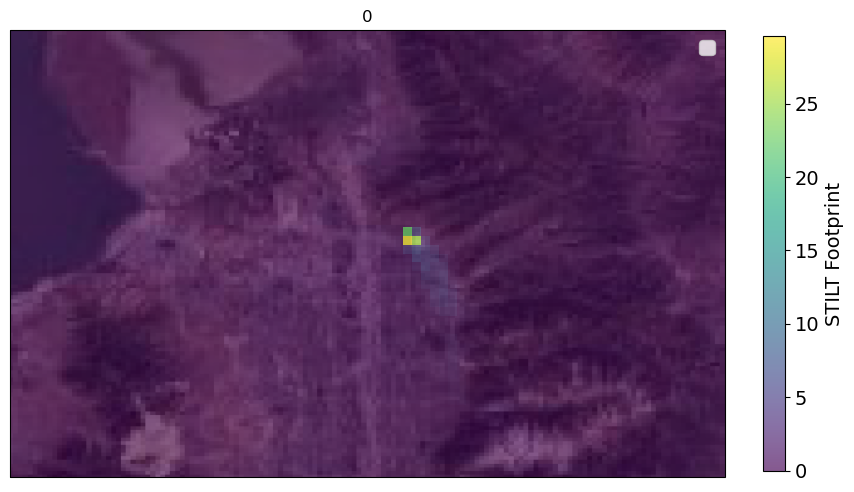

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


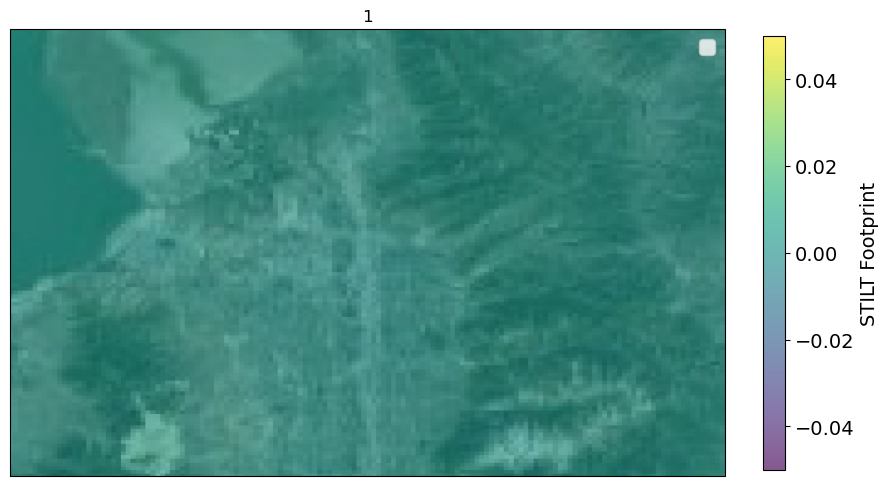

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


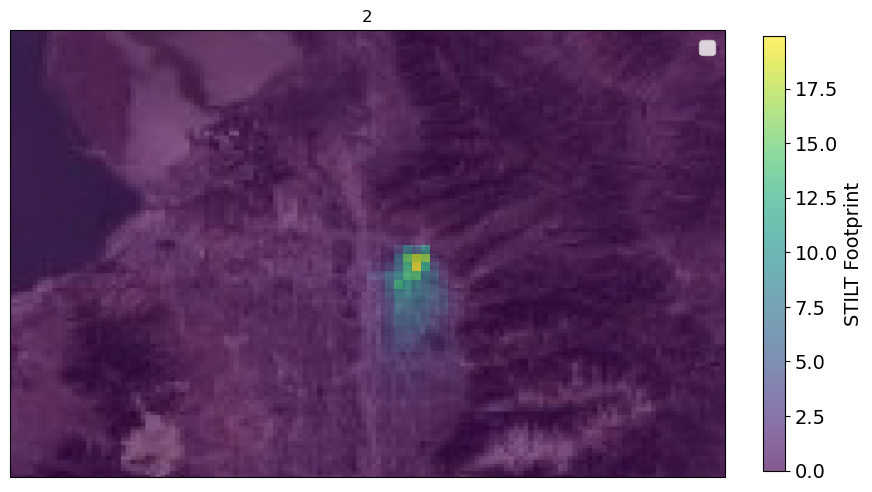

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


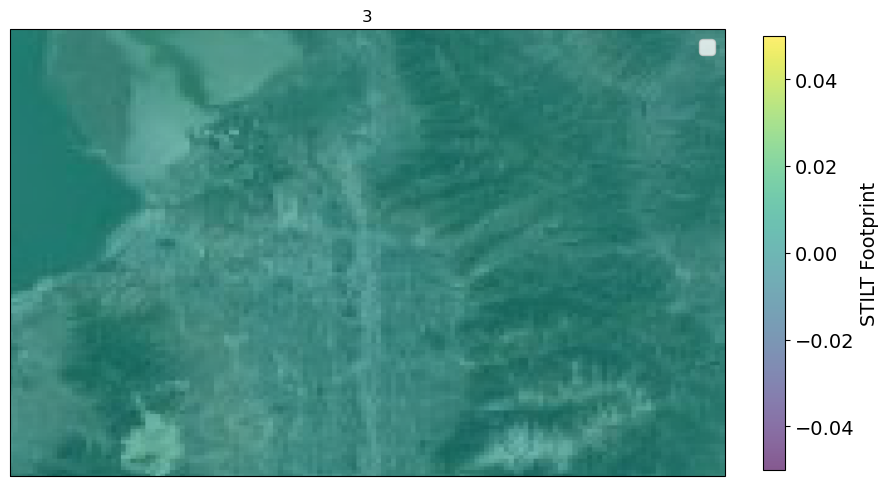

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


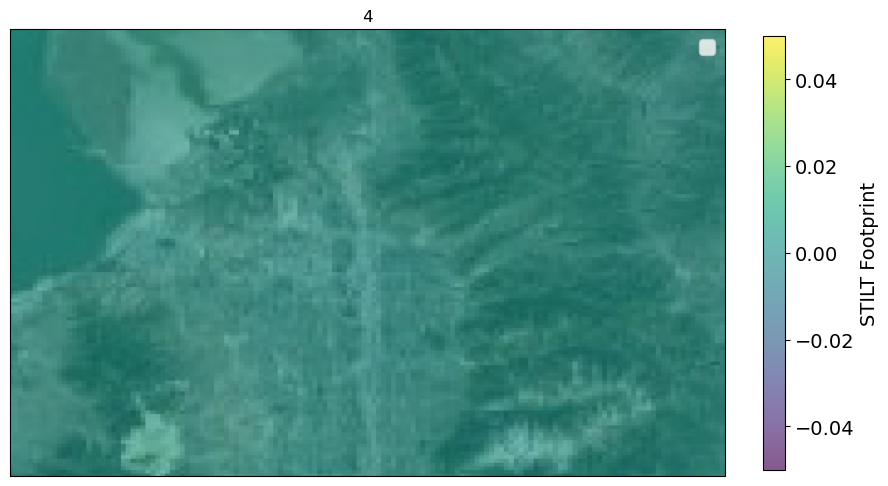

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


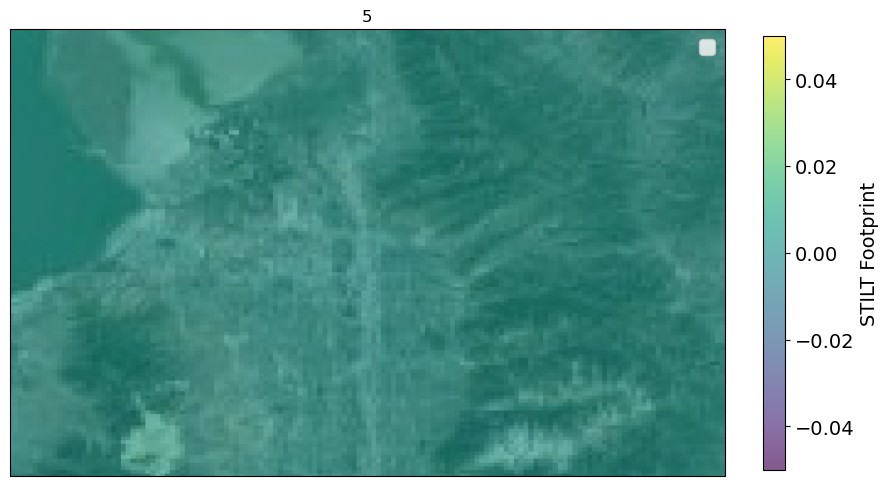

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyboardInterrupt: 

In [152]:
inst_lat = 40.766
inst_lon = -111.847
labsize = 14
zoom = 2
proj = ccrs.PlateCarree()


#sim_id = 0
for sim_id in combined_dataset.sim_id.values:
    extent=[-112.3,-111.5,40.5,41.0]

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection = proj)
    ax.set_extent(extent,crs=proj)

    request = cimgt.GoogleTiles(style='satellite')
    scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
    ax.add_image(request,int(scale))
    footplot = combined_dataset.sel({'sim_id':sim_id}).footxsim.plot(ax=ax,transform=proj,add_colorbar=False,alpha = 0.65)
    cbar = plt.colorbar(footplot,fraction=0.028)
    cbar.ax.tick_params(labelsize=labsize)
    cbar.set_label(label = 'STILT Footprint',size=labsize)


    ax.legend(fontsize=labsize,loc = 0)
    plt.title(sim_id)
    plt.gcf().autofmt_xdate()
    plt.show()

In [114]:
split_rec_df['run_times'].dt.tz_convert('US/Mountain')

0    2023-07-11 08:00:00-06:00
1    2023-07-11 08:00:00-06:00
2    2023-07-11 08:00:00-06:00
3    2023-07-11 08:00:00-06:00
4    2023-07-11 08:00:00-06:00
5    2023-07-11 08:00:00-06:00
6    2023-07-11 08:00:00-06:00
7    2023-07-11 08:00:00-06:00
8    2023-07-11 08:00:00-06:00
9    2023-07-11 08:00:00-06:00
10   2023-07-11 08:00:00-06:00
Name: run_times, dtype: datetime64[ns, US/Mountain]